In [1]:
import Scrapers.ackerman_scraper as ack_scraper
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import datetime as dt
from visualizations_helpers import *

In [2]:
raw = ack_scraper.dataframe_ackerman_auction()

{1202: '187 Oct 12, 2018 (NY)', 1197: '185A Sep 22, 2018 (HK)', 1196: '186 Sep 7, 2018 (NY)', 1192: '185 Jun 20, 2018 (NY)', 1190: '184A Jun 9, 2018 (HK)', 1188: '184 May 16, 2018 (NY)', 1187: '183A Apr 21, 2018 (HK)', 1185: '183 Apr 7, 2018 (NY)', 1184: '182A Mar 24, 2018 (HK)', 1181: '182 Mar 10, 2018 (NY)', 1179: '181 Feb 9, 2018 (NY)', 1177: '181A Jan 27, 2018 (HK)', 1174: '179 Dec 13, 2017 (NY)', 1173: '177A Dec 9, 2017 (HK)', 1172: '178 Nov 18, 2017 (NY)', 1170: '176A Nov 4, 2017 (HK)', 1168: '177 Oct 13, 2017 (NY)', 1165: '175A Sep 23, 2017 (HK)', 1163: '176 Sep 9, 2017 (NY)'}
1202 187 Oct 12, 2018 (NY)
1197 185A Sep 22, 2018 (HK)
1196 186 Sep 7, 2018 (NY)
1192 185 Jun 20, 2018 (NY)
1190 184A Jun 9, 2018 (HK)
1188 184 May 16, 2018 (NY)
1187 183A Apr 21, 2018 (HK)
1185 183 Apr 7, 2018 (NY)
1184 182A Mar 24, 2018 (HK)
1181 182 Mar 10, 2018 (NY)
1179 181 Feb 9, 2018 (NY)
1177 181A Jan 27, 2018 (HK)
1174 179 Dec 13, 2017 (NY)
1173 177A Dec 9, 2017 (HK)
1172 178 Nov 18, 2017 (NY)
117

In [3]:
raw.head()

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,None,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,bn sdc,None,1,None,,bottle,3968.0,1982,Chateau Angelus
1,None,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,None,1,None,,bottle,3968.0,1983,Chateau Angelus
2,None,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,spc,None,1,None,,bottle,3968.0,1985,Chateau Angelus
3,None,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,None,1,None,,bottle,3968.0,1988,Chateau Angelus
4,None,1202,"187 Oct 12, 2018 (NY)",1,1 bottle,,None,1,None,,bottle,3968.0,1990,Chateau Angelus


In [4]:
raw.shape

(31962, 14)

In [5]:
# need to group by lot number, append most rows, but the price seems to be static so don't sum that
# for now,  filtering away mixed lots by saying anything that has shared lot numbers shoudl be removed

df = raw.drop_duplicates(subset=['Auction.ID', 'LotNo'], keep=False)
df = df.reset_index()
df.shape

(13394, 15)

In [6]:
df.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,39,None,1202,"187 Oct 12, 2018 (NY)",6,6 bottles,1lbsl,None,6,None,,bottle,4340.0,1998,Chateau Cheval Blanc
1,40,None,1202,"187 Oct 12, 2018 (NY)",6,6 bottles,,None,7,None,,bottle,4712.0,2000,Chateau Cheval Blanc
2,60,None,1202,"187 Oct 12, 2018 (NY)",12,12 bottles,1x12 bottle owc,None,11,None,,bottle,2108.0,2000,Chateau Cos d'Estournel
3,61,None,1202,"187 Oct 12, 2018 (NY)",24,24 bottles,1lscl 1spc 3vlscl,None,12,None,,bottle,2480.0,2001,Chateau Cos d'Estournel
4,62,None,1202,"187 Oct 12, 2018 (NY)",12,12 bottles,,None,13,None,,bottle,2480.0,2003,Chateau Cos d'Estournel


# Dataframe raw enrichments

In [7]:
# convert to dollars
HKDUSD = 0.1277
def toUSD(row):
    if 'HK' in row['Auction.Name']:
       return row['SoldAmount'] * HKDUSD
    else:
       return row['SoldAmount'] 

df['SoldAmountUSD'] = df.apply( toUSD, axis = 1 )
    
# compute unit price by bottle
df['UnitPriceUSD'] = df[ 'SoldAmountUSD' ] / df[ 'BottleQuantity' ]

date_col = 'Date'
#Extract Date from Auction.Name column
date_search_regex = '[a-zA-Z]{3} .* \\d{4}'
df[date_col] = df['Auction.Name'].apply(lambda s: re.search(date_search_regex, s).group())
df[date_col] = pd.to_datetime(df[date_col])

In [8]:
# bottle sizes only for now
bottle_df = df[(df["BottleSummary"].str.contains("bottle") == True) & (df["BottleSummary"].str.contains("half") == False)]
bottle_df.shape

(10924, 18)

In [9]:
#some like Burgundys or champagnes need ProducerAndDesignation WITH Wine
unique_bottle_keys = ['Vintage', "Wine", "ProducerAndDesignation"]
#for Bordeauxs they are often all the same
bottle_grouped = bottle_df.groupby(unique_bottle_keys).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
bottle_grouped = bottle_grouped.reset_index()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)

In [10]:
mouton_grouped = bottle_grouped[ bottle_grouped["ProducerAndDesignation"].str.contains("Mouton") ]

In [11]:
mouton_all = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains( "Mouton") ]

In [12]:
mouton_grouped.head()

,Vintage,Wine,ProducerAndDesignation,min,mean,max,count
2431,2000,Chateau Mouton Rothschild,Chateau Mouton Rothschild,1766.346400,1999.909783,2365.642500,25
897,1982,Chateau Mouton Rothschild,Chateau Mouton Rothschild,992.000000,1215.591410,1482.000000,23
1096,1986,Chateau Mouton Rothschild,Chateau Mouton Rothschild,806.000000,905.878661,1033.333333,23
1710,1995,Chateau Mouton Rothschild,Chateau Mouton Rothschild,499.413417,535.796175,568.333333,10
2103,1998,Chateau Mouton Rothschild,Chateau Mouton Rothschild,473.128500,558.360074,633.392000,9


In [13]:
mouton_1982 = mouton_all[ mouton_all['Vintage'] == "1945"]

In [14]:
mouton_1982.head()

# the cheap one "believed to be" that vintage, which may explain low price

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
5998,119,None,1184,"182A Mar 24, 2018 (HK)",1,1 bottle,believed to be 1945 bsl cuc excellent color hs...,None,109,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,69440.0,1945,Chateau Mouton Rothschild,8867.488,8867.488,2018-03-24
6565,382,None,1181,"182 Mar 10, 2018 (NY)",1,1 bottle,cc cuc excellent color hs lbsl,None,234,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,11780.0,1945,Chateau Mouton Rothschild,11780.000,11780.000,2018-03-10
8634,524,None,1177,"181A Jan 27, 2018 (HK)",1,1 bottle,hs lstl outstanding color scc scl spc,None,437,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,98800.0,1945,Chateau Mouton Rothschild,12616.760,12616.760,2018-01-27
9170,1104,None,1174,"179 Dec 13, 2017 (NY)",1,1 bottle,averys of bristol private cellar cc fl hbsl ht...,None,546,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12350.0,1945,Chateau Mouton Rothschild,12350.000,12350.000,2017-12-13
9707,629,None,1173,"177A Dec 9, 2017 (HK)",2,2 bottles,1hs 1sdc 1vhs 2lstl 2scc 2scl avery family cel...,None,468,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,296400.0,1945,Chateau Mouton Rothschild,37850.280,18925.140,2017-12-09


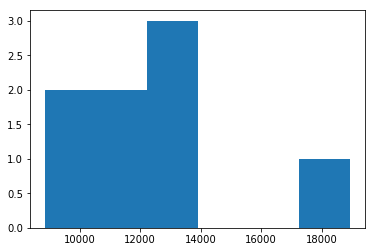

In [15]:
plt.hist( mouton_1982[ 'UnitPriceUSD'], 6 )
plt.show()

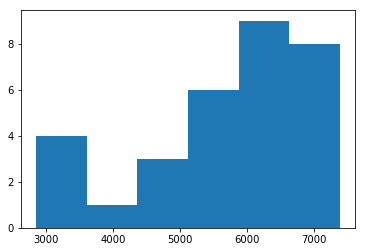

In [16]:
Vintage = "1999"
Producer = "Domaine de la Romanee Conti"
Wine = "La Tache"
producer_only = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains(Producer) ]
producer_wine = producer_only[ producer_only["Wine"].str.contains(Wine) ]

producer_wine_vintage = producer_wine[ producer_wine['Vintage'] == Vintage ]

plt.hist( producer_wine_vintage['UnitPriceUSD'], 6 )
plt.show()

In [17]:
producer_wine_vintage.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD,Date
866,447,None,1197,"185A Sep 22, 2018 (HK)",6,6 bottles,1x6 bottle banded owc,None,317,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,297600.0,1999,La Tache,38003.520,6333.920000,2018-09-22
2750,1371,None,1192,"185 Jun 20, 2018 (NY)",1,1 bottle,,None,1069,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,5952.0,1999,La Tache,5952.000,5952.000000,2018-06-20
2994,1682,None,1192,"185 Jun 20, 2018 (NY)",12,12 bottles,1x12 bottle owc 3 bottles different importer,None,1372,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,74400.0,1999,La Tache,74400.000,6200.000000,2018-06-20
3259,375,None,1190,"184A Jun 9, 2018 (HK)",3,3 bottles,,None,295,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,138880.0,1999,La Tache,17734.976,5911.658667,2018-06-09
3331,482,None,1190,"184A Jun 9, 2018 (HK)",3,3 bottles,1vlbsl,None,377,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,158720.0,1999,La Tache,20268.544,6756.181333,2018-06-09


In [18]:
bottle_profit = bottle_grouped[ bottle_grouped["max"] / 1.25 > bottle_grouped["min"] ]
bottle_profit = bottle_profit.reset_index()
bottle_profit['diff'] = bottle_profit['max'] / 1.25 - bottle_profit['min']
bottle_profit = bottle_profit[ bottle_profit["count"] > 10 ]
bottle_profit = bottle_profit.sort_values('diff', ascending = False)
bottle_profit

,index,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,diff
4,2314,1999,Romanee Conti,Domaine de la Romanee Conti,10028.706667,18481.627333,23224.373333,24,8550.792000
2,2274,1999,La Tache,Domaine de la Romanee Conti,2841.666667,5658.579462,7389.573333,31,3069.992000
39,2195,1999,Chambertin,A. Rousseau,899.000000,2914.087885,4960.000000,13,3069.000000
42,1321,1990,Chambertin,A. Rousseau,3224.000000,4757.275897,7750.000000,13,2976.000000
66,2850,2002,Romanee Conti,Domaine de la Romanee Conti,12616.760000,15934.525697,19001.760000,11,2584.648000
23,1897,1996,La Tache,Domaine de la Romanee Conti,1900.176000,3809.081699,4712.000000,17,1869.424000
17,2308,1999,Richebourg,Domaine de la Romanee Conti,1583.480000,3090.456851,4133.333333,19,1723.186667
6,1424,1990,La Tache,Domaine de la Romanee Conti,5046.704000,6756.803725,8445.226667,23,1709.477333
50,257,1959,Chateau Latour,Chateau Latour,1261.676000,2235.981806,3705.000000,12,1702.324000
53,2801,2002,La Tache,Domaine de la Romanee Conti,3087.500000,4043.022417,5806.093333,12,1557.374667


In [19]:
bottle_profit.shape

(73, 9)

In [20]:
#TODO list!
#check auction scraping - all web and in person? looks like for 1 year lookback total
#PnL 
#Trend over time
#Expected inventory, distributions of profit? strategies? always buy < max?)
#Lot sizes makes difference?
#Ullage level?
#Label condition?
#mixed lots built from single bottles?

# Price momentum over time
For each unique bottle type - [Vintage, Wine, ProducerAndDesignation], use the historical price time series to compute the Annual Percent Change. Fit a linear regression through the price points as a function of ordinal date, then normalize to get the annual percent change. Interpret the Annual Percent Change as the price drift over time.
Also plot the price time series

In [21]:
# Start w/ the bottle dataframe - all lots of just type. UnitPriceUSD represents the per bottle price 
# Treat each lot as an individual observation. Get the slope of Price(Time). Slope will represent the marginal change in price per marginal change in time
bottle_grouped = bottle_df.groupby(unique_bottle_keys).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
#bottle_df.head()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)
#bottle_grouped.head()

In [22]:
bottle_df_with_grouped_attr = pd.merge(bottle_df, bottle_grouped.reset_index(), on=unique_bottle_keys)
bottle_df_with_grouped_attr = bottle_df_with_grouped_attr.sort_values('count', ascending = False)
count_threshold = 20
count_col = 'count'
high_count_bottles = bottle_df_with_grouped_attr[bottle_df_with_grouped_attr[count_col] >= count_threshold]
# show high count bottles w/ annual percent change
bottle_grouped_percent_change = high_count_bottles.groupby(unique_bottle_keys).apply(lambda x: pd.Series({annual_percent_change_col: regress_bottle_price_time(x)}))
bottle_grouped_percent_change = pd.merge(bottle_grouped.reset_index(), bottle_grouped_percent_change.reset_index(), on=unique_bottle_keys)
bottle_grouped_percent_change = bottle_grouped_percent_change.sort_values(annual_percent_change_col, ascending = False)
bottle_grouped_percent_change

,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,Annual Percent Change
8,1996,Salon Vintage Champagne,"Le Mesnil, salon",516.666667,595.232250,930.000000,22,0.463745
15,2005,Chateau Montrose,Chateau Montrose,136.681567,170.678998,190.017600,20,0.411694
10,2014,Screaming Eagle Cabernet Sauvignon,Screaming Eagle,2058.333333,2386.788121,2893.333333,22,0.328531
1,2005,La Tache,Domaine de la Romanee Conti,3995.307333,5212.178071,6333.920000,33,0.320160
12,2009,La Tache,Domaine de la Romanee Conti,3154.190000,4123.083612,5278.266667,22,0.268991
2,1999,La Tache,Domaine de la Romanee Conti,2841.666667,5658.579462,7389.573333,31,0.264146
9,1989,Chateau Haut Brion,Chateau Haut Brion,1441.000000,1740.169664,2480.000000,22,0.253545
4,1999,Romanee Conti,Domaine de la Romanee Conti,10028.706667,18481.627333,23224.373333,24,0.244511
6,1990,La Tache,Domaine de la Romanee Conti,5046.704000,6756.803725,8445.226667,23,0.233602
13,2003,Chateau Leoville Poyferre,Chateau Leoville Poyferre,112.272727,154.877556,186.000000,22,0.172401


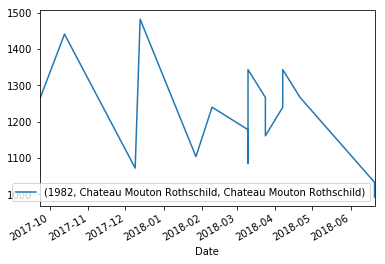

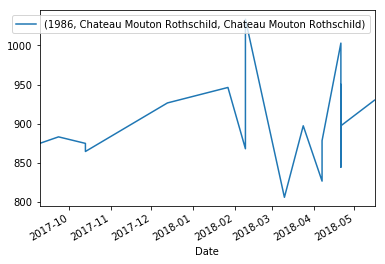

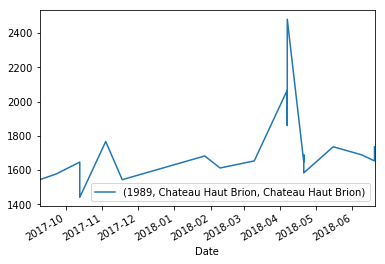

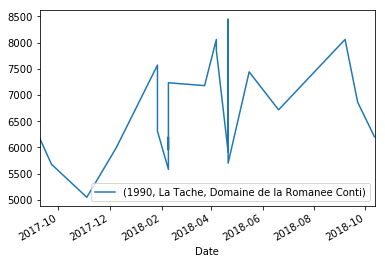

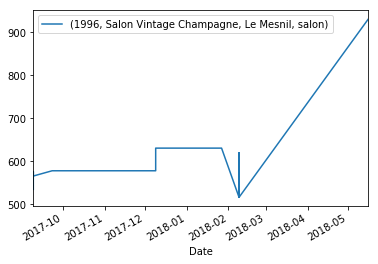

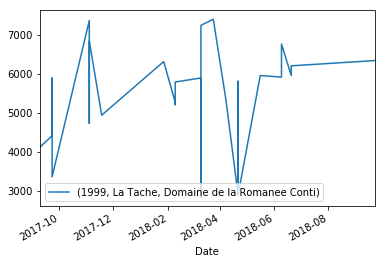

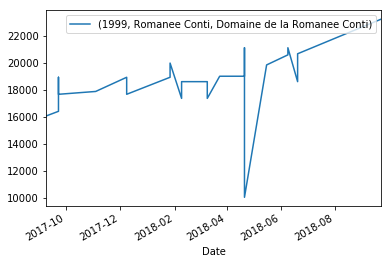

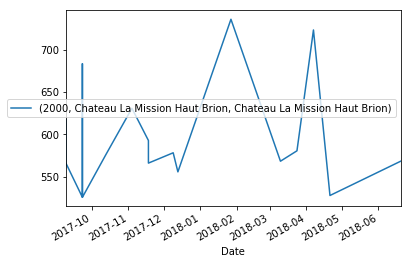

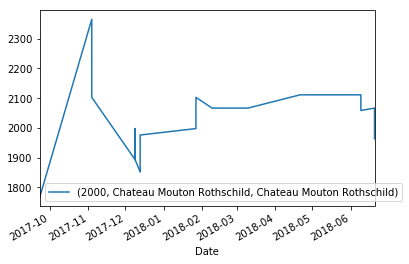

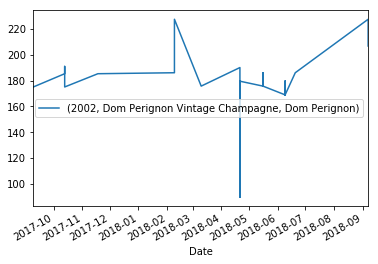

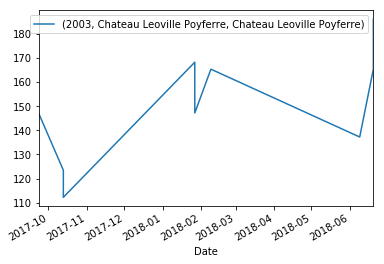

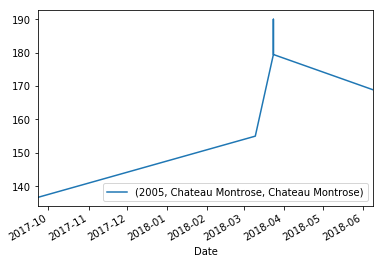

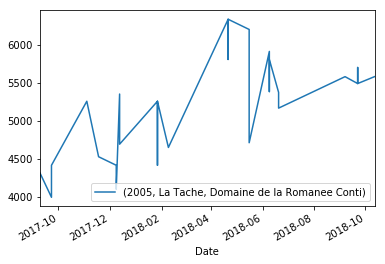

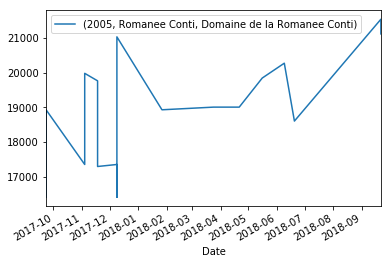

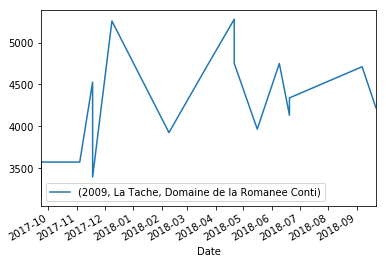

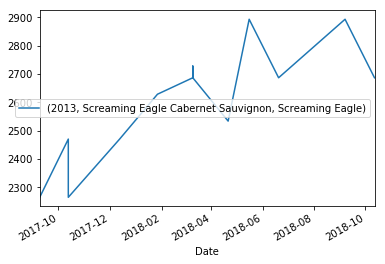

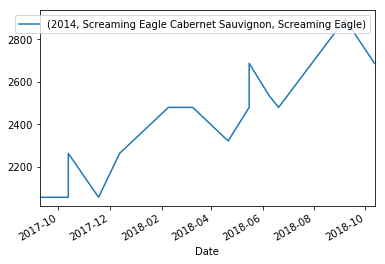

In [23]:
for unique_bottle_key, single_bottle_timeseries in high_count_bottles.groupby(unique_bottle_keys):
    plot_price_over_time(single_bottle_timeseries)